# Patent Funding Modeling -- Subsample Analysis 

### Import required packages and load dataset 

In [1]:
# general packages
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
#warnings.filterwarnings("ignore")
import pickle

# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix,classification_report

# imbelearn package
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('modeling.csv', sep = ',')

# print first few rows of df 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3166 entries, 0 to 3165
Data columns (total 41 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Unnamed: 0                                        3166 non-null   int64  
 1   Disclosure_Date                                   3166 non-null   float64
 2   Country_WIPO_ID                                   3166 non-null   float64
 3   Actually_File_Date                                3166 non-null   float64
 4   Is_Priority                                       3166 non-null   float64
 5   Lawfirm                                           3166 non-null   float64
 6   Attorney                                          3166 non-null   float64
 7   Number_of_Inventors                               3166 non-null   float64
 8   Application_Type                                  3166 non-null   float64
 9   Lead_Inventor      

### Model Preprocessing

In [3]:
# drop unamed column 
df = df.drop(df.columns[0], axis=1)

# Remove row with null patent_status
df = df.dropna(subset=['Patent_Status'])

# convert funding status to binary 
df.loc[df['Patent_Status']=='no_fund', 'Patent_Status'] = 0
df.loc[df['Patent_Status']=='fund', 'Patent_Status'] = 1
df["Patent_Status"] = df.Patent_Status.astype(float)

df.head()

,Disclosure_Date,Country_WIPO_ID,Actually_File_Date,Is_Priority,Lawfirm,Attorney,Number_of_Inventors,Application_Type,Lead_Inventor,Division_Department,...,topic1,topic2,topic3,lda_topic,Patents_in_Division,Successful Patents_in_Division,Division_Patent_Success_Rate,Patents_in_Tech,Disclosure_to_Filing,Patent_Status
0,0.372629,0.941860,0.370048,1.0,0.701031,0.659722,0.000000,0.888889,0.331307,0.633333,...,0.042594,0.895720,0.065075,0.5,1.0,1.0,0.379626,0.000000,0.510944,0.0
1,0.571259,0.941860,0.561741,1.0,0.154639,0.881944,0.000000,0.888889,0.145897,0.006667,...,0.018785,0.736053,0.251967,0.5,1.0,1.0,0.379626,0.000000,0.502780,0.0
2,0.782425,0.941860,0.793953,1.0,0.701031,0.812500,0.111111,0.666667,0.872340,0.746667,...,0.034030,0.432757,0.545258,1.0,1.0,1.0,0.379626,0.000000,0.529453,0.0
3,0.617259,0.058140,0.710370,0.0,0.701031,0.812500,0.166667,1.000000,0.589666,0.406667,...,0.884092,0.058615,0.058616,0.0,1.0,1.0,0.379626,0.089888,0.630657,0.0
4,0.617259,0.104651,0.658887,0.0,0.701031,0.812500,0.166667,0.444444,0.589666,0.406667,...,0.884092,0.058615,0.058616,0.0,1.0,1.0,0.379626,0.089888,0.566542,0.0


### Break out population subsets 

In [4]:
# individual topics 
df_top1 = df[(df['lda_topic']==0.0)]
df_top2 = df[(df['lda_topic']==0.5)]
df_top3 = df[(df['lda_topic']==1.0)]

# individual Divisions  
df_BSD = df[(df['Primary_Division']==0.25)]
df_PSD = df[(df['Primary_Division']==1.00)]
df_ANL = df[(df['Primary_Division']==0.00)]
df_PME = df[(df['Primary_Division']==0.75)]
df_Other = df[(df['Primary_Division']==0.50)]

In [5]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Keeping the highly correlated features attains higher model scoring, so we will keep
to_drop

# # Drop features 
#df.drop(to_drop, axis=1, inplace=True)

<ipython-input-5-69866c654d74>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


['Actually_File_Date', 'Successful Patents_in_Division']

In [6]:
def get_modeling_datasets(df):
    X = df.iloc[:, 0:39]
    y = df.iloc[:, 39]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

    # Employment of SMOTE to oversample skewed funding outputs. This yields better results 
    sm = SMOTE()
    x_train, y_train = sm.fit_resample(x_train, y_train)
    
    pipelines = []
    # Standard binary classification models 
    pipelines.append(('LogisticRegression', Pipeline([('LR',linear_model.LogisticRegression(max_iter=1000))])))
    pipelines.append(('KNearestNeighbors', Pipeline([('KNN',KNeighborsClassifier(algorithm = 'brute', n_jobs=-1))])))
    pipelines.append(('LinearSVC', Pipeline([('SVC',LinearSVC(C=0.0001))])))
    pipelines.append(('DecisionTree', Pipeline([('DTREE',DecisionTreeClassifier())])))
    # Employment of ensemble learning 
    pipelines.append(('BaggingClassifier', Pipeline([('BAG',BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10))])))
    pipelines.append(('BoostClassifier', Pipeline([('BOOST',AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6))])))
    pipelines.append(('RandomForest', Pipeline([('FOREST',RandomForestClassifier(n_estimators=30, max_depth=9))])))
    pipelines.append(('GradientBoost', Pipeline([('GBoost',GradientBoostingClassifier())])))

    results = []
    names = []
    for name, model in pipelines:
        kfold = KFold(n_splits=10, random_state=21, shuffle=True)
        cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='f1')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

### The model is very accurate with Topic 2, but less accurate on Topics 1 and 3 compared to total dataset

In [7]:
# Compare Scores for different breakouts 
print('\nTotal Dataset Outputs----------------------------\n')
get_modeling_datasets(df)

print('\nTopic 1 Model Outputs----------------------------\n')
get_modeling_datasets(df_top1)

print('\nTopic 2 Model Outputs----------------------------\n')
get_modeling_datasets(df_top2)

print('\nTopic 3 Model Outputs----------------------------\n')
get_modeling_datasets(df_top3)


Total Dataset Outputs----------------------------

LogisticRegression: 0.853162 (0.019971)
KNearestNeighbors: 0.922252 (0.014515)
LinearSVC: 0.796389 (0.015534)
DecisionTree: 0.927919 (0.014652)
BaggingClassifier: 0.942655 (0.012351)
BoostClassifier: 0.936481 (0.006216)
RandomForest: 0.932634 (0.008670)
GradientBoost: 0.936951 (0.008195)

Topic 1 Model Outputs----------------------------

LogisticRegression: 0.847674 (0.027219)
KNearestNeighbors: 0.897901 (0.026488)
LinearSVC: 0.751821 (0.040554)
DecisionTree: 0.904414 (0.019122)
BaggingClassifier: 0.906564 (0.026206)
BoostClassifier: 0.898594 (0.014812)
RandomForest: 0.930331 (0.022968)
GradientBoost: 0.920382 (0.025793)

Topic 2 Model Outputs----------------------------

LogisticRegression: 0.900156 (0.013635)
KNearestNeighbors: 0.938323 (0.011638)
LinearSVC: 0.813623 (0.047698)
DecisionTree: 0.934349 (0.019024)
BaggingClassifier: 0.938146 (0.011520)
BoostClassifier: 0.940330 (0.011370)
RandomForest: 0.949257 (0.013557)
GradientBoos

### Combining Topics 1 and 3 does not improve scoring much when comparing against the individual topic scores

In [8]:
df_top1_top3 = pd.concat([df_top1, df_top3])

# Compare Scores for different breakouts 
print('\nTotal Dataset Outputs----------------------------\n')
get_modeling_datasets(df)

print('\nTopic 1 and Topic 3 Model Outputs----------------------------\n')
get_modeling_datasets(df_top1_top3)

print('\nTopic 2 Model Outputs----------------------------\n')
get_modeling_datasets(df_top2)


Total Dataset Outputs----------------------------

LogisticRegression: 0.850217 (0.022377)
KNearestNeighbors: 0.921066 (0.010085)
LinearSVC: 0.795213 (0.017640)
DecisionTree: 0.920689 (0.012324)
BaggingClassifier: 0.930280 (0.014546)
BoostClassifier: 0.933260 (0.016634)
RandomForest: 0.936164 (0.013666)
GradientBoost: 0.928844 (0.016496)

Topic 1 and Topic 3 Model Outputs----------------------------

LogisticRegression: 0.813056 (0.028043)
KNearestNeighbors: 0.904673 (0.026717)
LinearSVC: 0.746652 (0.036075)
DecisionTree: 0.897677 (0.014520)
BaggingClassifier: 0.910977 (0.018284)
BoostClassifier: 0.910159 (0.018548)
RandomForest: 0.926276 (0.015917)
GradientBoost: 0.912233 (0.021068)

Topic 2 Model Outputs----------------------------

LogisticRegression: 0.899453 (0.029890)
KNearestNeighbors: 0.938864 (0.014523)
LinearSVC: 0.805891 (0.060191)
DecisionTree: 0.930473 (0.020922)
BaggingClassifier: 0.935235 (0.020989)
BoostClassifier: 0.941886 (0.017149)
RandomForest: 0.952462 (0.015198)


### The model is very accurate for BSD inventions, but much less accurate for other divisions. 81% of Topic 2 records are BSD, which makes sense given Topic 2 and BSD both perform very well within the model  

In [9]:
# Compare Scores for different breakouts 
print('\nTotal Dataset Outputs----------------------------\n')
get_modeling_datasets(df)

print('\nBSD Model Outputs----------------------------\n')
get_modeling_datasets(df_BSD)

print('\nPSD Model Outputs----------------------------\n')
get_modeling_datasets(df_PSD)

print('\nANL Model Outputs (Not possible to model because there are no successful patents in this Division----------------------------\n')
#get_modeling_datasets(df_ANL)

print('\nPME Model Outputs----------------------------\n')
get_modeling_datasets(df_PME)

print('\nOther Model Outputs----------------------------\n')
get_modeling_datasets(df_Other)


Total Dataset Outputs----------------------------

LogisticRegression: 0.851059 (0.013566)
KNearestNeighbors: 0.916188 (0.014190)
LinearSVC: 0.790477 (0.015096)
DecisionTree: 0.926458 (0.013897)
BaggingClassifier: 0.932888 (0.015874)
BoostClassifier: 0.935608 (0.012707)
RandomForest: 0.936349 (0.012060)
GradientBoost: 0.926432 (0.013542)

BSD Model Outputs----------------------------

LogisticRegression: 0.902664 (0.018886)
KNearestNeighbors: 0.950258 (0.010523)
LinearSVC: 0.836145 (0.016067)
DecisionTree: 0.953768 (0.012637)
BaggingClassifier: 0.957942 (0.011919)
BoostClassifier: 0.955522 (0.008186)
RandomForest: 0.959734 (0.010589)
GradientBoost: 0.958830 (0.011702)

PSD Model Outputs----------------------------

LogisticRegression: 0.754041 (0.036622)
KNearestNeighbors: 0.821813 (0.057066)
LinearSVC: 0.670409 (0.049166)
DecisionTree: 0.874242 (0.067801)
BaggingClassifier: 0.872712 (0.049560)
BoostClassifier: 0.870826 (0.031458)
RandomForest: 0.883854 (0.054022)
GradientBoost: 0.896

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


DecisionTree: 0.666667 (0.447214)
BaggingClassifier: 0.166667 (0.341565)
BoostClassifier: 0.533333 (0.452155)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


RandomForest: 0.633333 (0.433333)
GradientBoost: 0.533333 (0.452155)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


### Non-BSD records perform quite a bit worse than BSD records. 

In [10]:
df_non_BSD = pd.concat([df_PSD, df_ANL, df_PME, df_Other])

# Compare Scores for different breakouts 
print('\nTotal Dataset Outputs----------------------------\n')
get_modeling_datasets(df)

print('\nAll Non-BSD Model Outputs----------------------------\n')
get_modeling_datasets(df_non_BSD)

print('\nBSD Model Outputs----------------------------\n')
get_modeling_datasets(df_BSD)


Total Dataset Outputs----------------------------

LogisticRegression: 0.854349 (0.017011)
KNearestNeighbors: 0.913322 (0.015468)
LinearSVC: 0.794294 (0.022688)
DecisionTree: 0.921629 (0.016742)
BaggingClassifier: 0.939286 (0.014077)
BoostClassifier: 0.932326 (0.013594)
RandomForest: 0.941010 (0.015541)
GradientBoost: 0.932754 (0.015825)

All Non-BSD Model Outputs----------------------------

LogisticRegression: 0.782542 (0.039098)
KNearestNeighbors: 0.852913 (0.027598)
LinearSVC: 0.692532 (0.051354)
DecisionTree: 0.898086 (0.033370)
BaggingClassifier: 0.896981 (0.045886)
BoostClassifier: 0.886994 (0.031807)
RandomForest: 0.904591 (0.034563)
GradientBoost: 0.921958 (0.031312)

BSD Model Outputs----------------------------

LogisticRegression: 0.893305 (0.015610)
KNearestNeighbors: 0.946653 (0.016012)
LinearSVC: 0.829546 (0.019264)
DecisionTree: 0.947245 (0.018378)
BaggingClassifier: 0.955072 (0.012180)
BoostClassifier: 0.958638 (0.011915)
RandomForest: 0.956128 (0.014242)
GradientBoos

### Merge records in Topic 2 or BSD in one dataset and all other records in another dataset 

In [11]:
df_BSD_top2 = df[(df['lda_topic']==0.5) | (df['Primary_Division']==0.25)]
df_Non_BSD_top2 = df[(df['lda_topic']!=0.5) & (df['Primary_Division']!=0.25)]


print('Total Dataset', df.shape)
print('Records in Topic 2 or BSD', df_BSD_top2.shape)
print('Records that are Non-BSD & Not in Topic 2', df_Non_BSD_top2.shape)

Total Dataset (3165, 40)
Records in Topic 2 or BSD (2629, 40)
Records that are Non-BSD & Not in Topic 2 (536, 40)


In [12]:
# Compare Scores for different breakouts 
print('\nTotal Dataset Outputs----------------------------\n')
get_modeling_datasets(df)

print('\nRecords in Topic 2 or BSD----------------------------\n')
get_modeling_datasets(df_BSD_top2)

print('\nRecords that are Non-BSD & Not in Topic 2----------------------------\n')
get_modeling_datasets(df_Non_BSD_top2)


Total Dataset Outputs----------------------------

LogisticRegression: 0.850025 (0.022401)
KNearestNeighbors: 0.921843 (0.016506)
LinearSVC: 0.791273 (0.024876)
DecisionTree: 0.918955 (0.015093)
BaggingClassifier: 0.932540 (0.012895)
BoostClassifier: 0.924661 (0.013816)
RandomForest: 0.933504 (0.013623)
GradientBoost: 0.925471 (0.011553)

Records in Topic 2 or BSD----------------------------

LogisticRegression: 0.882826 (0.020178)
KNearestNeighbors: 0.937537 (0.015041)
LinearSVC: 0.814132 (0.020217)
DecisionTree: 0.939946 (0.012756)
BaggingClassifier: 0.946492 (0.014311)
BoostClassifier: 0.948558 (0.010397)
RandomForest: 0.946490 (0.012713)
GradientBoost: 0.945636 (0.015974)

Records that are Non-BSD & Not in Topic 2----------------------------

LogisticRegression: 0.735407 (0.068887)
KNearestNeighbors: 0.821325 (0.025024)
LinearSVC: 0.662695 (0.069688)
DecisionTree: 0.843501 (0.057972)
BaggingClassifier: 0.851047 (0.050132)
BoostClassifier: 0.842950 (0.046684)
RandomForest: 0.871355

# Takeaway: If we do a subsample, I would recommend breaking out by Topic2 and Non-Topic 2, as this yielded the optimal outputs for the subsamples

In [13]:
X_top2 = df_top2.iloc[:, 0:39]
y_top2 = df_top2.iloc[:, 39]
x_train_top2, x_test_top2, y_train_top2, y_test_top2 = train_test_split(X_top2, y_top2, test_size = 0.2, stratify = y_top2)

# Employment of SMOTE to oversample skewed funding outputs. This yields better results 
sm = SMOTE()
x_train_top2, y_train_top2 = sm.fit_resample(x_train_top2, y_train_top2)

In [14]:
X_top1_top3 = df_top1_top3.iloc[:, 0:39]
y_top1_top3 = df_top1_top3.iloc[:, 39]
x_train_top1_top3, x_test_top1_top3, y_train_top1_top3, y_test_top1_top3 = train_test_split(X_top1_top3, y_top1_top3, test_size = 0.2, stratify = y_top1_top3)

# Employment of SMOTE to oversample skewed funding outputs. This yields better results 
sm = SMOTE()
x_train_top1_top3, y_train_top1_top3 = sm.fit_resample(x_train_top1_top3, y_train_top1_top3)

### Model Outputs - Random Forest 

### While model accuracy improves in the Topic 2 model, recall goes down significantly. Because we do recall is so important to the Polsky Center (we do not want to lose any True Positives) the team recommends not subsetting the dataset


Gradient Boosting Classifier Confusion Matrix
 [[189  13]
 [ 10  37]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


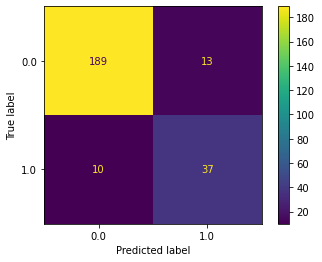


Logistic Regression Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.95      0.94      0.94       202
         1.0       0.74      0.79      0.76        47

    accuracy                           0.91       249
   macro avg       0.84      0.86      0.85       249
weighted avg       0.91      0.91      0.91       249


Accuracy: 0.908


In [15]:
#Produce and save the model, then load and apply the model.
rfc = RandomForestClassifier(n_estimators=30, max_depth=9)
rfc.fit(x_train_top2, y_train_top2)
rfc_predictions = rfc.predict(x_test_top2)

rfc_matrix = metrics.confusion_matrix(y_test_top2,rfc_predictions)
print("\nGradient Boosting Classifier Confusion Matrix\n",rfc_matrix)

plot_confusion_matrix(rfc, x_test_top2, y_test_top2)  
plt.show()

class_report_rfc = classification_report(y_test_top2, rfc_predictions)
print("\nLogistic Regression Confusion Matrix\n",class_report_rfc)

print("\nAccuracy:",round(metrics.accuracy_score(y_test_top2,rfc_predictions),3))


Gradient Boosting Classifier Confusion Matrix
 [[248  22]
 [ 19  96]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


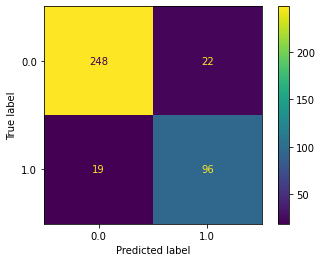


Logistic Regression Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.93      0.92      0.92       270
         1.0       0.81      0.83      0.82       115

    accuracy                           0.89       385
   macro avg       0.87      0.88      0.87       385
weighted avg       0.89      0.89      0.89       385


Accuracy: 0.894


In [16]:
#Produce and save the model, then load and apply the model.
rfc = RandomForestClassifier(n_estimators=30, max_depth=9)
rfc.fit(x_train_top1_top3, y_train_top1_top3)
rfc_predictions = rfc.predict(x_test_top1_top3)

rfc_matrix = metrics.confusion_matrix(y_test_top1_top3,rfc_predictions)
print("\nGradient Boosting Classifier Confusion Matrix\n",rfc_matrix)

plot_confusion_matrix(rfc, x_test_top1_top3, y_test_top1_top3)  
plt.show()

class_report_rfc = classification_report(y_test_top1_top3, rfc_predictions)
print("\nLogistic Regression Confusion Matrix\n",class_report_rfc)

print("\nAccuracy:",round(metrics.accuracy_score(y_test_top1_top3,rfc_predictions),3))